<a href="https://colab.research.google.com/github/siddhusalvi/Covid-Data-Visualization/blob/CasesDistribution/Covid_Data_Visualisation_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

Mounting Google Drive

In [ ]:
!pip install plotly==4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
import plotly.graph_objects as go

In [4]:
path = '/content/drive/My Drive/Siddhu/data/nation_data.csv'

In [5]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,DateType
from pyspark.sql.functions import col,when,isnull

In [6]:
schema = StructType() \
      .add("Date",DateType(),True) \
      .add("DailyConfirmed",IntegerType(),True) \
      .add("TotalCases",IntegerType(),True) \
      .add("DailyRecovered",IntegerType(),True) \
      .add("TotalRecovered",IntegerType(),True) \
      .add("DailyDeceased",IntegerType(),True) \
      .add("TotalDeceased",IntegerType(),True) 
      

In [7]:
nationDataDF = spark.read\
.format('csv')\
.schema(schema)\
.option("dateFormat", "dd/MM/YYYY")\
.option("header",True)\
.load(path)

In [ ]:
nationDataDF.count()

In [ ]:
nationDataDF.show(1)

In [ ]:
nationDataDF.printSchema

In [11]:
import plotly.graph_objects as go

In [12]:
date = nationDataDF.toPandas()['Date']
dailyConfirmed = nationDataDF.toPandas()['DailyConfirmed']
totalCases = nationDataDF.toPandas()['TotalCases']
dailyRecovered = nationDataDF.toPandas()['DailyRecovered']
totalRecovered = nationDataDF.toPandas()['TotalRecovered']
dailyDeceased = nationDataDF.toPandas()['DailyDeceased']
totalDeceased = nationDataDF.toPandas()['TotalDeceased']

# Cases Visualization



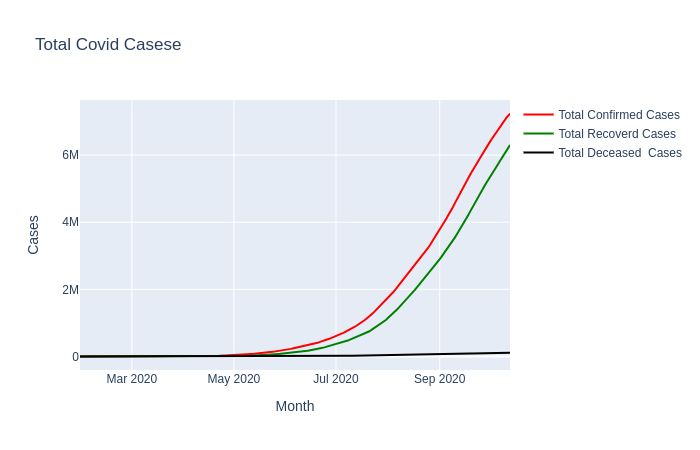

In [13]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=totalCases, name='Total Confirmed Cases',line=dict(color='red')))
fig.add_trace(go.Scatter(x=date, y=totalRecovered, name='Total Recoverd Cases',line=dict(color='green')))
fig.add_trace(go.Scatter(x=date, y=totalDeceased, name='Total Deceased  Cases',line=dict(color='black')))

fig.update_layout(title='Total Covid Casese',xaxis_title='Month', yaxis_title='Cases')

fig.show('png')

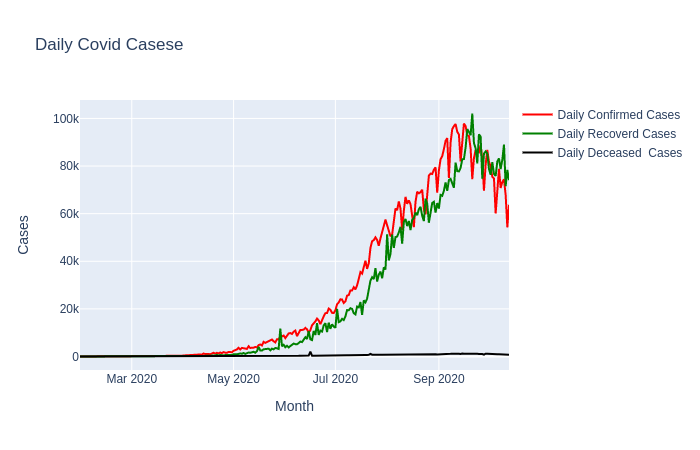

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=dailyConfirmed, name='Daily Confirmed Cases',line=dict(color='red')))
fig.add_trace(go.Scatter(x=date, y=dailyRecovered, name='Daily Recoverd Cases',line=dict(color='green')))
fig.add_trace(go.Scatter(x=date, y=dailyDeceased, name='Daily Deceased  Cases',line=dict(color='black')))

fig.update_layout(title='Daily Covid Casese',xaxis_title='Month', yaxis_title='Cases')

fig.show('png')

In [15]:
fig = go.Figure()
fig.add_trace(go.Bar(x=date,
                y=totalRecovered,
                name='Daily Recovred Cases',
                marker_color = 'ForestGreen'
                ))
fig.add_trace(go.Bar(x=date,
                y=totalCases,
                name='Total Cases',
                marker_color = 'DarkSlateGrey'
                ))
fig.add_trace(go.Bar(x=date,
                y=totalDeceased,
                name='Total Deaths',
                marker_color = 'red'
                ))
fig.update_layout(
    title='Covid cases',
    barmode = 'relative'
)
fig.show()

In [16]:
activeCaseses = totalCases - totalRecovered - totalDeceased

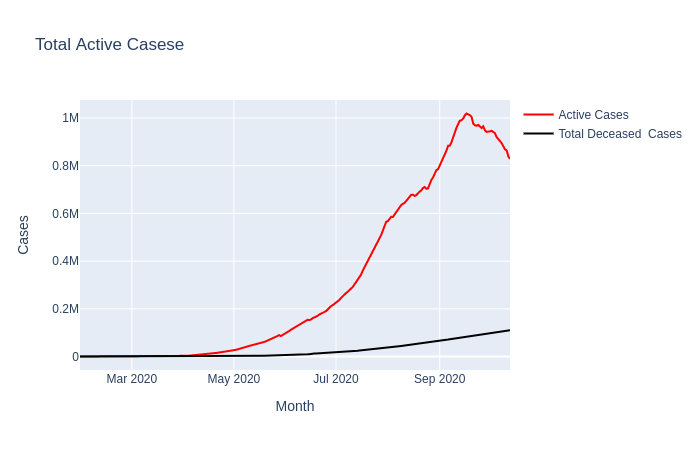

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date, y=activeCaseses, name='Active Cases',line=dict(color='red')))
fig.add_trace(go.Scatter(x=date, y=totalDeceased, name='Total Deceased  Cases',line=dict(color='black')))
fig.update_layout(title='Total Active Casese',xaxis_title='Month', yaxis_title='Cases')

fig.show('png')

In [18]:
patientData = ['ActiveCases','RecoveredCases','DeceasedCases']
totalPatients = nationDataDF.agg({"TotalCases": "max"}).collect()[0][0]
recoveredPatients = nationDataDF.agg({"TotalRecovered": "max"}).collect()[0][0]
deceasedPatients = nationDataDF.agg({"TotalDeceased": "max"}).collect()[0][0]
activePatients = totalPatients - recoveredPatients - deceasedPatients
patientValues =[activePatients,recoveredPatients,deceasedPatients]

In [19]:

import plotly.express as px
fig = px.pie(names=patientData, values=patientValues, title="Current Cases",color=patientData,color_discrete_map={'ActiveCases':'#008080','RecoveredCases':'#2F4F4F','DeceasedCases':'#000000'})
fig.show('png')

In [ ]:
recoveryRateDf = nationDataDF.withColumn('RecoveryRate',10*(col('TotalRecovered')/(col('TotalCases')-col('TotalRecovered')-col('TotalDeceased'))))\
.withColumn('ActiveCases',col('TotalCases')-col('TotalRecovered')-col('TotalDeceased'))\
.filter(col('RecoveryRate')>0)
recoveryRateDf.show(300)
recoveryDate = recoveryRateDf.toPandas()['Date']
recoveryRate = recoveryRateDf.toPandas()['RecoveryRate']

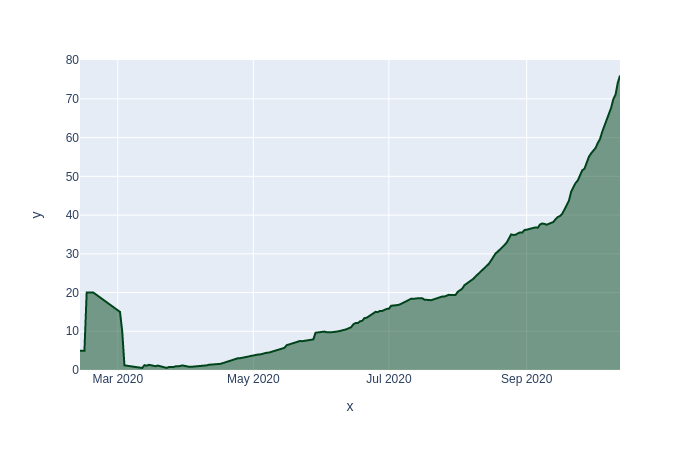

In [22]:
fig = px.area(x=recoveryDate,y=recoveryRate,color_discrete_sequence=px.colors.sequential.Greens_r)
fig.show('png')